In [1]:
import numpy as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

import chugunov_indicator as chug
from chugunov_indicator.graphing import SliderGraph

We make the assumption that our intercept function is separable, i.e.
$$
    C(\bar{A}, \overline{Z^2}, Z_1, Z_2) = C_0 + C_1(\overline{Z^2}) + C_2(\bar{A}) + C_3(Z_1, Z_2)
$$
for some constant $C_0$ and functions $C_1, C_2, C_3$. Based on the results of the previous notebook, we assume that $C$ is independent of $\bar{Z}, A_1, A_2$.

To test this, we need to examine slices of $C$ on a 4D grid for $\bar{A}, \overline{Z^2}, Z_1, Z_2$.

In [2]:
T_ = np.logspace(7, 9.35, 100)
D_ = np.logspace(-4, 8, 100)

T, D = np.meshgrid(T_, D_)

In [3]:
minmaxes = {
    "abar": (1, 75),
    "z2bar": (10**0, 10**3),
    "z1": (1, 25),
    "z2": (1, 25)
}

linspaces = {param: np.linspace(*bounds, 100) for param, bounds in minmaxes.items()}
linspaces["z2bar"] = np.logspace(0, 3, 100)

In [4]:
def configuration_space(x: str) -> tuple[dict, dict]:
    minmaxes_ = {**minmaxes}
    del minmaxes_[x]

    X = {x: linspaces[x][...]}
    return X, minmaxes_

def C(X, params) -> np.ndarray:
    X = {x: v[..., None, None, None] for x, v in X.items()}
    return chug.fitting.intercept_from_vars(T, D, **X, **params).squeeze()

First, we make a plot of $C_1(\overline{Z^2})$.

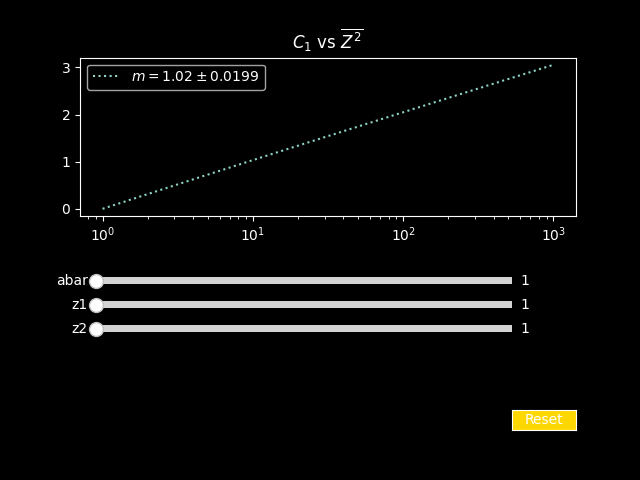

In [5]:
%matplotlib widget

fig1, ax1 = plt.subplots()

X1, minmaxes1 = configuration_space("z2bar")

graph1 = SliderGraph(fig1, ax1, minmaxes1)
graph1.fig.subplots_adjust(bottom=0.55)

graph1.ax.set_title("$C_1$ vs $\\overline{Z^2}$")
graph1.ax.set_xscale("log")

mins1 = {k: v[0] for k, v in minmaxes1.items()}
z2bar = linspaces["z2bar"]
log_z2bar = np.log10(z2bar)

C1 = C(X1, mins1)
C1 -= (y0 := C1[0])

line1, = graph1.ax.plot(z2bar, C1, linestyle="dotted")

def update1(val=None) -> None:
    C1 = C(X1, graph1.slider_vals())
    C1 -= C1[0]
    line1.set_ydata(C1)

    grad = np.gradient(C1, log_z2bar)
    m, dm = grad.mean(), grad.std()
    line1.set_label(f"$m = {m:.2f} \\pm {dm:.3g}$")

    graph1.ax.legend()

graph1.update_func(update1)
graph1.update()

#fig1.show()

As revealed above, we have $C_1 \propto \log_{10} \overline{Z^2}$, with the proportionality constant $m$ being between 1 and 1.10, depending on the values of $Z_1, Z_2$. We can then average this slope over a grid of this data to find a reasonable slope to use for all cases.

In [6]:
_z2bar, _z1, _z2, _T, _D = np.meshgrid(
    z2bar[::10], linspaces["z1"][::10], linspaces["z2"][::10],
    T_, D_, sparse=True
)

_C = chug.fitting.intercept_from_vars(_T, _D, abar=1, z2bar=_z2bar, z1=_z1, z2=_z2)

In [7]:
grad = np.gradient(_C, log_z2bar[::10], axis=1)
M = grad.mean(axis=0)
(m1 := M.mean()), M.std()

(1.0298324707166073, 0.028324944137614712)

As such, we can safely set $C_1(\overline{Z^2}) = 1.03 \log_{10} \overline{Z^2}$.

From there, we make the graph for $\bar{A}$.

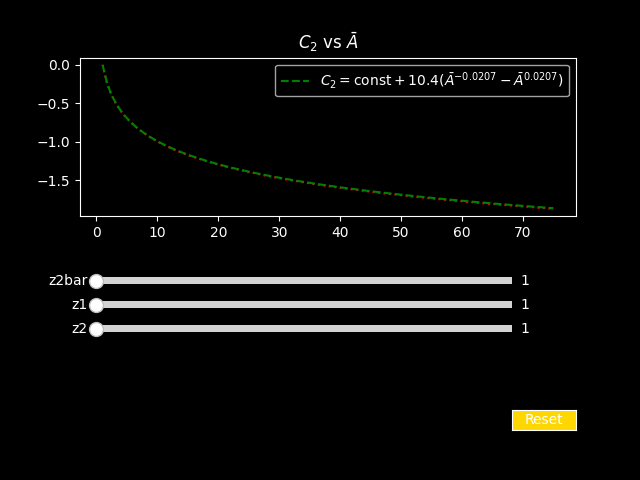

In [8]:
%matplotlib widget

fig2, ax2 = plt.subplots()

X2, minmaxes2 = configuration_space("abar")

graph2 = SliderGraph(fig2, ax2, minmaxes2)
graph2.fig.subplots_adjust(bottom=0.55)

graph2.ax.set_title("$C_2$ vs $\\bar{A}$")

mins2 = {k: v[0] for k, v in minmaxes2.items()}
abar = linspaces["abar"]

C2 = C(X2, mins2)
C2 -= (y0 := C2[0])

curve2, = graph2.ax.plot(abar, C2, linestyle="dotted", color="red")
predict2, = graph2.ax.plot(
    abar, _C2 := 10.4*(abar**(-0.0207) - abar**0.0207),
    linestyle="--", color="green"
)

predict2.set_label("$C_2 = \\mathrm{const} + 10.4(\\bar{A}^{-0.0207} - \\bar{A}^{0.0207})$")
graph2.ax.legend()

def update2(val=None) -> None:
    C2 = C(X2, graph2.slider_vals())
    C2 -= y0
    curve2.set_ydata(C2)
    predict2.set_ydata(_C2 + C2[0])

graph2.update_func(update2)
graph2.update()

#fig2.show()

Based on the shape of this graph, we anticipate a function of the form
$$
    C_2(\bar{A}) = a_2 (\bar{A}^{-k_2} - \bar{A}^{k_2}),
$$
for positive $a_2, k_2$ and $k_2$ small. We could allow for different coefficients and exponents on each of the terms, but the fit should be effective enough without that.

Since variations in $\overline{Z^2}, Z_1, Z_2$ only change the height of the graph, we don't have to fit on a grid this time.

In [9]:
def C2_func(abar: np.ndarray, a2: float, k2: float) -> np.ndarray:
    return a2 * (abar**(-k2) - abar**(k2))

In [10]:
popt, pcov = curve_fit(C2_func, abar, C2, p0=[8, 0.33])
popt, pcov

(array([10.41502026,  0.02076143]),
 array([[ 6.43761066e-01, -1.28067482e-03],
        [-1.28067482e-03,  2.54772856e-06]]))

In [11]:
a2, k2 = popt

A plot of $C_2$ with these parameters is included in the graph above.

Finally, while $C_3(Z_1, Z_2)$ is symmetric in $Z_1, Z_2$, we don't anticipate further separability, as `chugunov_2009` has a significant dependence on the product $Z_1 Z_2$.

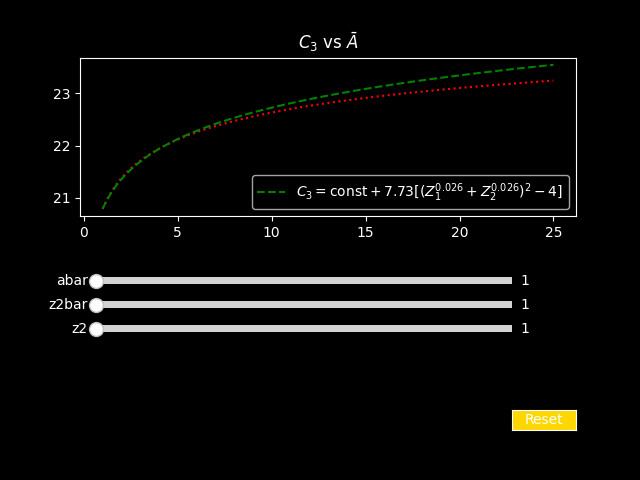

In [12]:
%matplotlib widget

fig3, ax3 = plt.subplots()

X3, minmaxes3 = configuration_space("z1")

graph3 = SliderGraph(fig3, ax3, minmaxes3)
graph3.fig.subplots_adjust(bottom=0.55)

graph3.ax.set_title("$C_3$ vs $\\bar{A}$")

mins3 = {k: v[0] for k, v in minmaxes3.items()}
z1 = linspaces["z1"]
z2 = mins3["z2"]

C3 = C(X3, mins3)
y0 = C3[0]

a3, k3 = 7.73078747, 0.02600378

curve3, = graph3.ax.plot(z1, C3, linestyle="dotted", color="red")
predict3, = graph3.ax.plot(z1, _C3 := y0 + a3*((z1**k3 + z2**k3)**2 - (1 + z2**k3)**2), linestyle="--", color="green")

predict3.set_label("$C_3 = \\mathrm{const} + 7.73[(Z_1^{0.026} + Z_2^{0.026})^2 - 4]$")
graph3.ax.legend()

def update3(val=None) -> None:
    C3 = C(X3, _slides := graph3.slider_vals())
    curve3.set_ydata(C3)

    z2 = _slides["z2"]
    _C3 = a3*((z1**k3 + z2**k3)**2 - (1 + z2**k3)**2)
    predict3.set_ydata(_C3 + C3[0])

graph3.update_func(update3)
graph3.update()

#fig3.show()

Lastly, we make the ansatz
$$
    C_3(Z_1, Z_2) = a_3 [(Z_1^{k_3} + Z_2^{k_3})^2 - 4]
$$
for positive $a_3, k_3$ and $k_3$ small. The exponent has to be $k_3$ for both by symmetry, and the term in parentheses is squared so that $C_3$ has a term proportional to $(Z_1 Z_2)^{k_3}$ in it.

In [13]:
def C3_func(Z: tuple[np.ndarray, np.ndarray], a3: float, k3: float) -> np.ndarray:
    return a3 * ((Z[0]**k3 + Z[1]**k3)**2 - 4)

In [14]:
_z1, _z2, _T, _D = np.meshgrid(
    __z1 := linspaces["z1"][::5], __z2 := linspaces["z2"][::5],
    T_, D_, sparse=True
)

_C = chug.fitting.intercept_from_vars(_T, _D, abar=1, z2bar=1, z1=_z1, z2=_z2)
_C -= chug.fitting.intercept_from_vars(_T, _D, abar=1, z2bar=1, z1=1, z2=1)

In [15]:
_z1_, _z2_ = np.meshgrid(__z1, __z2)
_z1_, _z2_ = _z1_.ravel(), _z2_.ravel()

In [16]:
popt, pcov = curve_fit(C3_func, (_z1_, _z2_), _C.ravel(), p0=[7.65, 0.0262])
popt, pcov

(array([7.73078747, 0.02600378]),
 array([[ 4.26855648e-01, -1.34298478e-03],
        [-1.34298478e-03,  4.22569821e-06]]))

In [17]:
a3, k3 = popt

Finally, since $C_1(1) = C_2(1) = C_3(1, 1) = 0$, we get $C_0 = C(1, 1, 1, 1)$.

In [18]:
C0 = chug.fitting.intercept_from_vars(_T, _D, abar=1, z2bar=1, z1=1, z2=1)[0, 0]
C0

20.791064415919347

With that, we can put together the final function for predicting whether screening can be fixed:
$$
    C(\bar{A}, \overline{Z^2}, Z_1, Z_2) \approx 20.79 + 1.03 \log_{10} \overline{Z^2} + 10.42(\bar{A}^{-0.02} - \bar{A}^{0.02}) + 7.73[(Z_1^{0.026} + Z_2^{0.026})^2 - 4].
$$
Absorbing all constant terms into $C_0$ simplifies this to
$$
    C(\bar{A}, \overline{Z^2}, Z_1, Z_2) \approx -10.132 + 1.03 \log_{10} \overline{Z^2} + 10.42(\bar{A}^{-0.02} - \bar{A}^{0.02}) + 7.73(Z_1^{0.026} + Z_2^{0.026})^2.
$$